# Load Packages

In [5]:
import math
import random

import numpy as np
from tqdm import tqdm

import pydot

import networkx.drawing.nx_pydot #import graphviz_layout
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF

import drawsvg as draw
from drawsvg import Drawing
from hyperbolic import euclid, util
from hyperbolic.poincare import *
from hyperbolic.poincare.util import (
    radial_euclid_to_poincare, radial_poincare_to_euclid,
    poincare_to_euclid_factor, triangle_side_for_angles,
)
import hyperbolic.tiles as htiles

## Draw Hyperbolic Disc - w. Geodesics

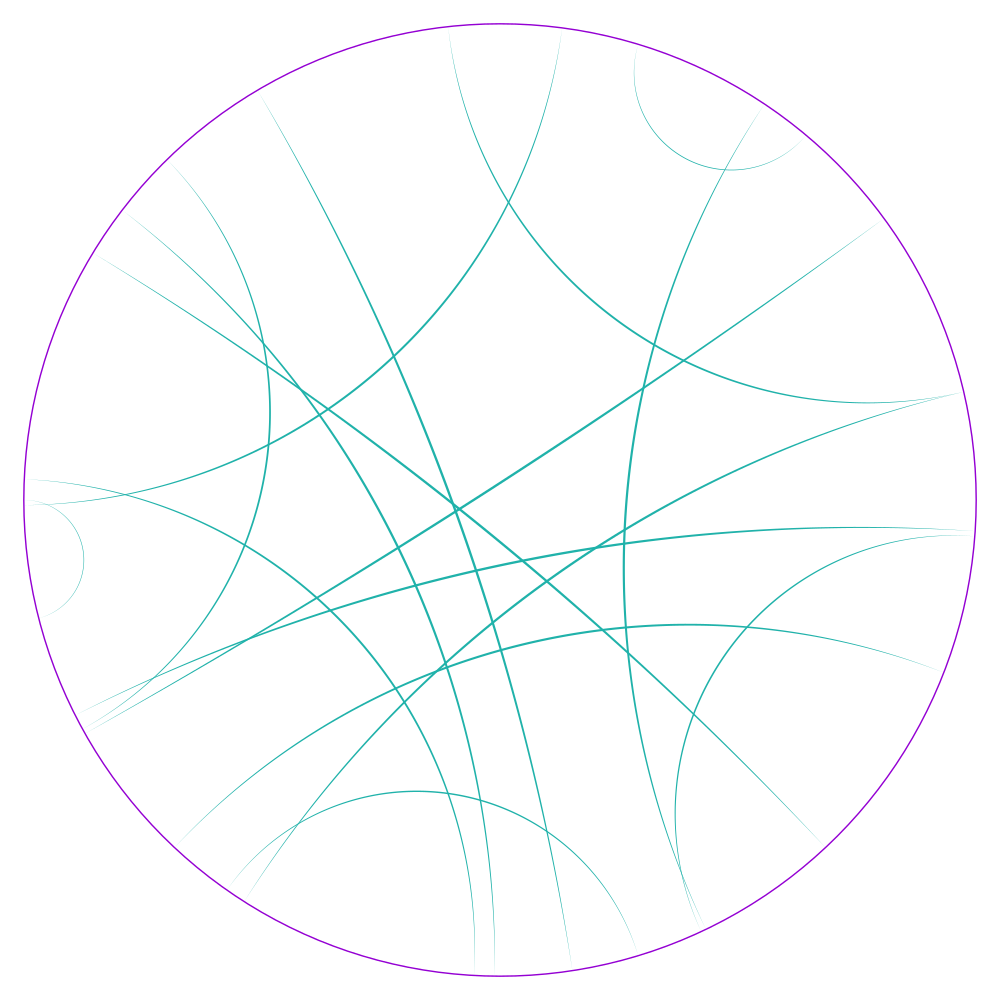

In [6]:
def draw_hyper_dragon(drawing, depth, a1=50, a2=-180, **style):
    if depth <= 0:
        hl = Line.from_points(
                *Ideal.from_degree(-a1), *Ideal.from_degree(-a2))
        drawing.draw(hl, **style)
    else:
        draw_hyper_dragon(drawing, depth-1, (a1+a2)/2, a2, **style)
        draw_hyper_dragon(drawing, depth-1, (a1+a2)/2+300, a1, **style)

d = Drawing(2.1, 2.1, origin='center')
d.draw(euclid.Circle(0, 0, 1),
       fill='none', stroke_width=0.003, stroke='darkviolet')
line_style = dict(hwidth=0.01, fill='lightseagreen')

draw_hyper_dragon(d, 4, **line_style)

d.set_render_size(w=1000)
d.save_svg('hyperbolic.svg')
# Convert to pdf
# drawing = svg2rlg("file.svg")
# renderPDF.drawToFile(d, "hyperbolic.pdf")
# View Plot
d 

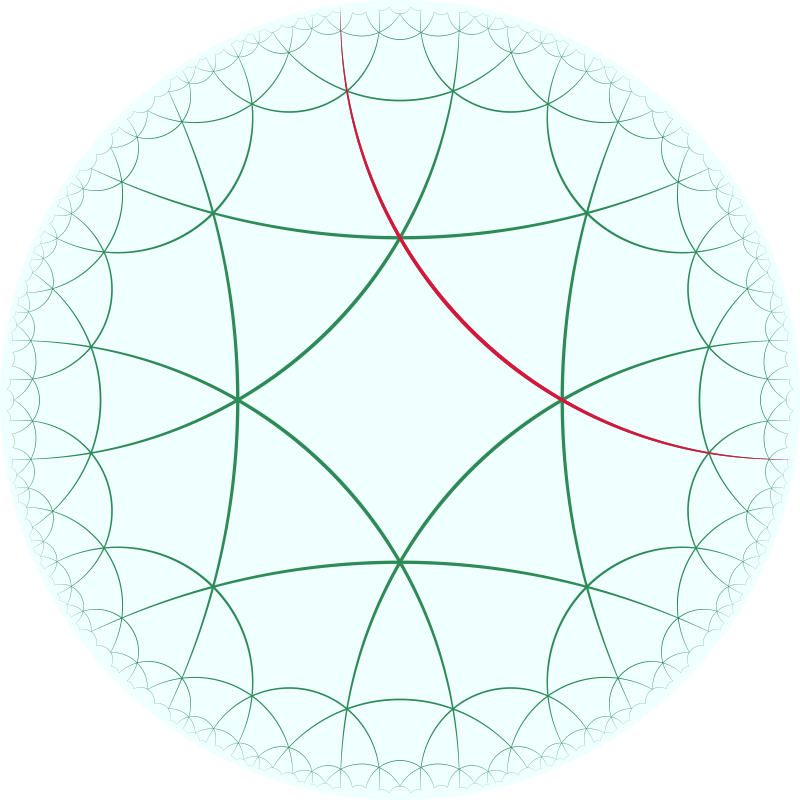

In [7]:
p1 = 4
p2 = 3
q = 3
rotate = 0

theta1, theta2 = math.pi*2/p1, math.pi*2/p2
phi_sum = math.pi*2/q
r1 = triangle_side_for_angles(theta1/2, phi_sum/2, theta2/2)
r2 = triangle_side_for_angles(theta2/2, phi_sum/2, theta1/2)

t_gen1 = htiles.TileGen.make_regular(p1, hr=r1, skip=1)
t_gen2 = htiles.TileGen.make_regular(p2, hr=r2, skip=1)

t_layout = htiles.TileLayout()
t_layout.add_generator(t_gen1, (1,)*p1)
t_layout.add_generator(t_gen2, (0,)*p2, htiles.TileDecoratorNull())
start_tile = t_layout.default_start_tile(rotate_deg=rotate)

t1 = start_tile
t2 = t_layout.place_tile(t1.sides[-1])
t3 = t_layout.place_tile(t2.sides[-1])
point_base = t3.vertices[-1]
points = [Transform.rotation(deg=-i*360/p1).apply_to_point(point_base)
          for i in range(p1)]
vertices = start_tile.vertices
edges = []
for i, point in enumerate(points):
    v1 = vertices[i]
    v2 = vertices[(i+1)%p1]
    edge = Hypercycle.from_points(*v1, *v2, *point, segment=True, exclude_mid=True)
    edges.append(edge)
decorate_poly = Polygon(edges=edges, vertices=vertices)
decorator1 = htiles.TileDecoratorPolygons(decorate_poly)
t_layout.set_decorator(decorator1, 0)

start_tile = t_layout.default_start_tile(rotate_deg=rotate)
tiles = t_layout.tile_plane(start_tile, depth=6)

d = Drawing(2, 2, origin='center')
d.draw(euclid.Circle(0, 0, 1), fill='azure')
for tile in tiles:
    d.draw(tile, hwidth=0.02, fill='seagreen')
tiles[0].decorator = None
d.draw(Hypercycle.from_points(
            *tiles[0].vertices[0], *tiles[0].vertices[1], *point_base
        ), hwidth=0.02, fill='crimson')

d.set_render_size(w=800)
d.save_svg('hyperbolic.svg')
d

# Trees

In [9]:
# Lazirly rename
import matplotlib as mpl
import matplotlib.pyplot as plt; plt.ion()

In [31]:
Nlevel = 8 # number of tree level
Nrep = 2 # number of leaves per node
seed = 2023 # seed parameter

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

"""
Generate tree.

INPUT:
 -Nlevel: number of tree level.
 -Nrep: number of leaves per node.
 -seed: seed parameter.
"""
def tree(Nlevel=6,Nrep=2,seed=42):
    np.random.seed(seed)

    # Construct tree
    G = nx.Graph()
    G.add_node(0)
    node_crt = 0
    node_prev = [0]
    index_list = [0]
    for i in range(Nlevel):
        node_prev_ = []
        while len(node_prev_)==0:
            for j in node_prev:
                for k in range(Nrep):
                    node_crt +=1 
                    G.add_node(node_crt)
                    G.add_edge(j, node_crt, weight=1)
                    node_prev_.append(node_crt)
                    index_list.append(node_crt)
        node_prev = node_prev_

    # Compute distance
    Npts = len(G.nodes)
    dist_tree = np.zeros((Npts,Npts))
    index_list = np.random.choice(index_list,len(index_list),replace=False)
    for i in tqdm(range(index_list.shape[0])):
        for j in range(index_list.shape[0]):
            dist_tree[i,j] = nx.dijkstra_path_length(G,index_list[i],index_list[j])
    dist_tree /= dist_tree.max()

    return G, dist_tree, index_list



In [ ]:
G, dist_tree, idx_origin = tree(Nlevel,Nrep,seed)

 29%|███████████▋                             | 146/511 [00:18<00:49,  7.34it/s]

In [ ]:
## Display tree with path to explore
path_explore = nx.shortest_path(G,87,117)
# path_explore = nx.shortest_path(G,351,471)

c1='#003eff' #blue
c2='#ff0080' #green
Nfr = len(path_explore)
col_gen = lambda i: colorFader(c1,c2,np.linspace(0,1,Nfr)[i])
col_list1 = [col_gen(i) for i in np.arange(Nfr)]

sz= 40
plt.figure(4,figsize=(12, 12))
plt.clf()
pos = graphviz_layout(G, prog="twopi")
nx.draw(G, pos, node_size=sz, node_color='darkorchid',alpha =0.9, width=1)
nx.draw_networkx_nodes(G, pos=pos, node_size=sz, nodelist=idx_origin, node_color='forestgreen',alpha =0.9)
nx.draw_networkx_nodes(G, pos=pos, node_size=sz*2, nodelist=path_explore, node_color=col_list1,alpha =0.9)

plt.savefig('Tree.pdf')

# Fin